In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.multioutput import ClassifierChain
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from matplotlib import pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.cross_validation import cross_val_score
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
%matplotlib inline

/usr/local/miniconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
## Importing datas from MSD and MXM
songs_dataset = pd.read_json('MasterSongList.json')
songs_dataset.head(5)

,_id,album,artist,audio_features,context,decades,genres,lyrics_features,moods,name,new_context,picture,recording_id,sub_context,yt_id,yt_views
0,{'$oid': '52fdfb440b9398049f3d7a8c'},Gangnam Style (강남스타일),PSY,"[11, 0.912744, 0.083704, 132.069, 0.293137, 0....",[work out],[],[pop],"[oppa, gangnam, style, gangnam, style, najeneu...","[energetic, motivational]",Gangnam Style (강남스타일),work out,http://images.musicnet.com/albums/073/463/405/...,50232.0,[working out: cardio],9bZkp7q19f0,2450112089
1,{'$oid': '52fdfb3d0b9398049f3cbc8e'},Native,OneRepublic,"[6, 0.7457039999999999, 0.11995499999999999, 1...",[energetic],[2012],[pop],"[lately, i, ve, been, i, ve, been, losing, sle...",[happy],Counting Stars,energetic,http://images.musicnet.com/albums/081/851/887/...,5839.0,[energy boost],hT_nvWreIhg,1020297206
2,{'$oid': '52fdfb420b9398049f3d3ea5'},Party Rock Anthem,LMFAO,"[5, 0.709932, 0.231455, 130.03, 0.121740999999...","[energetic, energetic, energetic, energetic]",[],[],"[party, rock, yeah, woo, let, s, go, party, ro...","[happy, celebratory, rowdy]",Party Rock Anthem,housework,http://images.musicnet.com/albums/049/414/127/...,52379.0,"[energy boost, pleasing a crowd, housework, dr...",KQ6zr6kCPj8,971128436
3,{'$oid': '52fdfb410b9398049f3d1eac'},Gentleman,PSY,"[3, 0.705822, 0.053292, 126.009, 0.126016, 0.0...","[party, party, party, party, party, party]",[2010s],[dance],"[alagamun, lan, weh, wakun, heya, hanun, gon, ...","[happy, energetic, celebratory]",Gentleman,energetic,http://images.musicnet.com/albums/082/950/461/...,12353.0,"[driving in the left lane, energy boost, girls...",ASO_zypdnsQ,892096527
4,{'$oid': '52fdfb400b9398049f3d0b19'},On The Floor,Jennifer Lopez,"[3, 0.741757, 0.07277399999999999, 129.985, 0....","[party, party]",[2000s],[reggaeton],"[j, lo, the, other, side, out, my, mine, it, s...",[energetic],On The Floor,work out,http://images.musicnet.com/albums/050/131/765/...,29502.0,"[working out: cardio, dance party: sweaty]",t4H_Zoh7G5A,873285189


In [3]:
# Preprocessing genres

def consolidate_genre(genre):
    if (len(genre) > 0):
        return genre.split(':')[0]
    else:
        return float('NaN')

songs_dataset.loc[:, 'genres'] = songs_dataset['genres'].apply(''.join)
songs_dataset.loc[:, 'genres'] = songs_dataset['genres'].apply(consolidate_genre)

In [4]:
audio_feature_headers = ['key', 
                         'energy', 
                         'liveliness', 
                         'tempo', 
                         'speechiness', 
                         'acousticness', 
                         'instrumentalness', 
                         'time_signature', 
                         'duration', 
                         'loudness', 
                         'valence', 
                         'danceability', 
                         'mode', 
                         'time_signature_confidence', 
                         'tempo_confidence', 
                         'key_confidence', 
                         'mode_confidence',
                        ]

df_features = pd.DataFrame(songs_dataset['audio_features'].values.tolist(), columns=audio_feature_headers)

In [5]:
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
df_features['genres'] = songs_dataset['genres']

In [6]:
# Filter and clean the df_features genres
df_features.dropna(inplace=True)
df_features.reset_index(inplace=True, drop=True)

In [7]:
from sklearn.utils import resample
dance_dataset = df_features.loc[(df_features['genres'] == 'dance')]
jazz_dataset = df_features.loc[(df_features['genres'] == 'jazz')]
country_dataset = df_features.loc[(df_features['genres'] == 'country')]
rock_dataset = df_features.loc[(df_features['genres'] == 'rock')]
randb_dataset = df_features.loc[(df_features['genres'] == 'r&b')]
rap_dataset = df_features.loc[(df_features['genres'] == 'rap')]
dubstep_dataset = df_features.loc[(df_features['genres'] == "dubstep & drum 'n' bass")]
reggaeton_dataset = df_features.loc[(df_features['genres'] == "reggaeton")]
pop_dataset = df_features.loc[(df_features['genres'] == "pop")]
electronica_dataset = df_features.loc[(df_features['genres'] == "electronica")]
classical_dataset = df_features.loc[(df_features['genres'] == "classical")]
indie_dataset = df_features.loc[(df_features['genres'] == "indie")]
latin_dataset = df_features.loc[(df_features['genres'] == "latin")]
blues_dataset = df_features.loc[(df_features['genres'] == "singer-songwriter")]
df_minority_upsampled = resample(reggaeton_dataset, 
                                 replace=True,  
                                 n_samples=700,  
                                 random_state=101)
df_dubstep_upsampled = resample(dubstep_dataset, 
                                 replace=True,  
                                 n_samples=700,  
                                 random_state=101)
df_features_final = pd.concat([dance_dataset, jazz_dataset, country_dataset, rock_dataset, randb_dataset, rap_dataset, df_dubstep_upsampled, df_minority_upsampled, pop_dataset, electronica_dataset, classical_dataset, indie_dataset, latin_dataset, blues_dataset])

In [9]:
df_features_final.head()

,key,energy,liveliness,tempo,speechiness,acousticness,instrumentalness,time_signature,duration,loudness,valence,danceability,mode,time_signature_confidence,tempo_confidence,key_confidence,mode_confidence,genres
2,3.0,0.705822,0.053292,126.009,0.126016,0.001966,0.000000,0.0,4.0,194.09333,-3.898,0.592798,0.875137,0.004,0.114,1.000,0.742,dance
14,0.0,0.616411,0.171423,130.009,0.059577,0.058936,0.000065,1.0,4.0,284.41333,-7.443,0.476111,0.789760,0.499,0.489,0.708,1.000,dance
27,7.0,0.728367,0.844810,112.328,0.307629,0.009750,0.000022,1.0,4.0,207.15057,-14.511,0.652412,0.691151,0.844,0.384,1.000,1.000,dance
51,11.0,0.687771,0.890427,118.388,0.069611,0.031731,0.000222,1.0,4.0,357.80000,-9.815,0.781912,0.771293,0.851,0.534,0.815,1.000,dance
56,6.0,0.650609,0.061545,122.677,0.066457,0.038270,0.000030,0.0,4.0,267.16000,-6.094,0.552483,0.844630,0.550,0.550,0.766,1.000,dance


In [8]:
# Scale the features
standard_scaler = StandardScaler()
X = standard_scaler.fit_transform(df_features_final.drop('genres', axis=1))
y = df_features_final['genres']

In [9]:
# Split df_features into X, y train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)

parameters = {'nthread':[4],
              'objective': ['binary:logistic'],
              'learning_rate': [0.05, 0.1, 0.3, 0.2],
              'max_depth': [6],
              'min_child_weight': [11],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [5, 1000],
              'missing':[-999],
              'seed': [1337]
             }

grid_search_cv = GridSearchCV(xgb, parameters, refit=True, n_jobs=-1)

result = grid_search_cv.fit(X_train, y_train)
params = result.best_params_

params

In [10]:
eval_set = [(X_train, y_train), (X_test, y_test)]

In [11]:
xgb = XGBClassifier(learning_rate=0.3, n_estimators=100, eval_set=eval_set)
xgb.fit(X_train, y_train)
predictions = xgb.predict(X_test)
report = classification_report(y_test, predictions)
print(report)

                         precision    recall  f1-score   support

              classical       0.59      0.61      0.60       151
                country       0.47      0.29      0.36       360
                  dance       0.58      0.56      0.57       672
dubstep & drum 'n' bass       0.76      0.68      0.72       229
            electronica       0.42      0.35      0.38       388
                  indie       0.32      0.14      0.20       615
                   jazz       0.50      0.62      0.55       622
                  latin       0.51      0.37      0.43       318
                    pop       0.24      0.06      0.09       229
                    r&b       0.40      0.39      0.39       792
                    rap       0.65      0.72      0.68       776
              reggaeton       0.87      0.97      0.92       220
                   rock       0.59      0.76      0.67      2182
      singer-songwriter       0.28      0.28      0.28       330

            avg / total

/usr/local/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


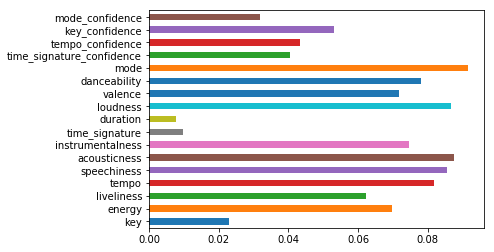

In [12]:
feat_importances = pd.Series(xgb.feature_importances_, index=audio_feature_headers)
feat_importances.plot(kind='barh')

In [13]:
import pickle
pickle.dump(xgb, open('trained_xgb.pickle', 'wb'))
o

In [14]:
print(len(df_features))

27161
